### Import relevant Libraries.

In [6]:
# Import Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import cv2
import os
import random
import math
from tqdm import tqdm
import sys

In [7]:
if torch.cuda.is_available():
  device = 'cuda'
  print("GPU is available. :-)")
else:
  device = 'cpu'
  print("GPU is not available. :-(")

GPU is available. :-)


# Importing Data.

In [ ]:
## Mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

Dataset Details: OUHANDS Dataset

| Item            | Train Data     | Test Data       |
|-----------------|-----------------|-----------------|
| Images | 2000 | 1000 |
| labels | A to K |  A to K |
| BB | x,y,w,h | x,y,w,h |
| Negetive | 3412 | 1874


Where:

* x, y  : bottom left corner absolute values, i.e. not normalized according to the image size.

* w, h  : width and height of image not normalized.

* Negetive : Images with no hands

* Every label has 200 corresponding Images.

## (Archive) Old Data Loading for base Model.

In [ ]:
root_path = "/content/drive/MyDrive/Data"
train_image_path = os.path.join(root_path,"Train/image")  # pic root path
train_boxes_path = os.path.join(root_path,"Train/bounding_box")  # box root path

test_image_path = os.path.join(root_path,"Test/image")
test_boxes_path = os.path.join(root_path,"Test/bounding_box")

train_image_path_list = []
train_boxes_path_list = []

test_image_path_list = []
test_boxes_path_list = []

# put all image path in image_path_list
for filepath in os.listdir(train_image_path):
    train_image_path_list.append(os.path.join(train_image_path,filepath))

for filepath in os.listdir(test_image_path):
    test_image_path_list.append(os.path.join(test_image_path,filepath))

# put all boxes path in boxes_path_list
for i in train_image_path_list:
    file_name = i.split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file_path = os.path.join(train_boxes_path, file_path)
    train_boxes_path_list.append(file_path)

for i in test_image_path_list:
    file_name = i.split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file_path = os.path.join(test_boxes_path, file_path)
    test_boxes_path_list.append(file_path)


train_data = []
test_data = []


for i in range(len(train_image_path_list)):

    img = Image.open(str(train_image_path_list[i]))
    img = np.array(img)
    if img.shape != (480, 640, 3):
        continue
    label = train_image_path_list[i].split("/")[-1].split("-")[0]
    '''Added by Mohit, check later for proper one hot encoding.'''
    label = one_hot_encode_local(label)

    file_name = train_image_path_list[i].split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file = os.path.join(train_boxes_path, file_path)
    bb1, bb2, bb3, bb4, x = np.loadtxt(str(file), skiprows=1, dtype=None, delimiter=" ", usecols=(0,1,2,3,4), unpack=False)

    train_data.append([img,label,bb1,bb2,bb3,bb4])

for i in range(len(test_image_path_list)):

    img = Image.open(str(test_image_path_list[i]))
    img = np.array(img)
    if img.shape != (480, 640, 3):
        continue
    label = test_image_path_list[i].split("/")[-1].split("-")[0]
    '''Added by Mohit Check later for proper implemention of One Hot encoding.'''
    label = one_hot_encode_local(label)

    file_name = test_image_path_list[i].split("/")[-1].split(".")[0]
    file_path = file_name + str(".txt")
    file = os.path.join(test_boxes_path, file_path)
    bb1, bb2, bb3, bb4, x = np.loadtxt(str(file), skiprows=1, dtype=None, delimiter=" ", usecols=(0,1,2,3,4), unpack=False)

    test_data.append([img,label,bb1,bb2,bb3,bb4])

## New Data Loading Code.

Load data into variable.

In [8]:
# path_to_data = '/content/drive/MyDrive/CVProject/'
path_to_data = ''

training_data_raw = np.load(path_to_data+'train_data.npy', allow_pickle=True).item()
testing_data_raw = np.load(path_to_data+'test_data.npy', allow_pickle=True).item()
# training_negetive_image = np.load(path_to_data+'negetive_data.npy', allow_pickle=True)
# test_negetive_image = np.load(path_to_data+'negetive_data_test.npy', allow_pickle=True)

Process training data.

In [9]:
print(type(training_data_raw['images'][0]))
print(type(training_data_raw['labels'][0]))
print(type(training_data_raw['bbxs'][0]))

<class 'numpy.ndarray'>
<class 'str'>
<class 'numpy.ndarray'>


In [10]:
def one_hot_encode(class_):
  ## This also adds the probabily of hand being in frame
  if class_ == 'A':
    label = [1, 0, 0]
  elif class_ == 'B':
    label = [0, 1, 0]
  else:
    label = [0, 0, 1]
  return label

In [11]:
def make_label(class_, bbx):
  label = one_hot_encode(class_)
  label = np.hstack((label, bbx))
  return label

In [12]:
def reshape_image(image, bbx, output_size):
  image_height, image_width = image.shape[0],image.shape[1]
  bbx_normalized = bbx/[image_width, image_height, image_width, image_height]
  ## reshape image.
  reshaped_image = cv2.resize(image, (640,output_size))
  # print('bbx in reshape :', bbx_normalized)
  return reshaped_image, bbx_normalized

In [13]:
training_images = []
bbxs_normalized = []
for image, bbx in tqdm(zip(training_data_raw['images'],training_data_raw['bbxs'])):
  reshaped_image, bbx_normalized = reshape_image(image, bbx, 480)
  training_images.append(reshaped_image)
  bbxs_normalized.append(bbx_normalized)

## Make labels.
training_labels = [make_label(class_, bbx) for class_,bbx in zip(training_data_raw['labels'],bbxs_normalized)]

2000it [00:00, 3966.22it/s]


In [14]:
testing_images = []
bbxs_normalized = []
for image, bbx in tqdm(zip(testing_data_raw['images'],testing_data_raw['bbxs'])):
  reshaped_image, bbx_normalized = reshape_image(image, bbx, 480)
  testing_images.append(reshaped_image)
  bbxs_normalized.append(bbx_normalized)

## Make labels.
testing_labels = [make_label(class_, bbx) for class_,bbx in zip(testing_data_raw['labels'],bbxs_normalized)]

1000it [00:00, 4024.13it/s]


In [15]:
class CustomDatasetSmall(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.as_tensor(self.images[idx], dtype = torch.float32)
        label = torch.as_tensor(self.labels[idx], dtype = torch.float32)
        return img, label

In [16]:
train_dataset = CustomDatasetSmall(training_images, training_labels)
test_dataset = CustomDatasetSmall(testing_images, testing_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

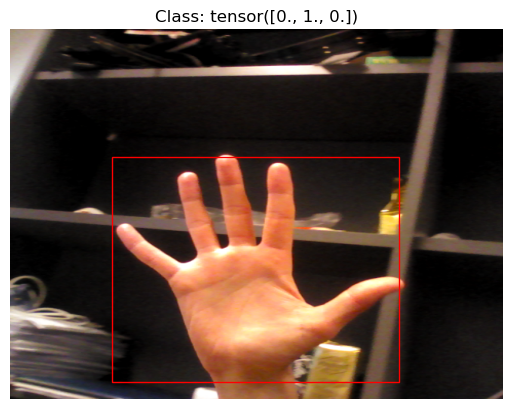

In [17]:
## Data Loading Test
for batch in train_dataloader:
    images, labels = batch

    for i in range(1):
        image = images[i]/255
        plt.imshow(image)
        plt.title(f'Class: {labels[i][:3]}')
        plt.gca().add_patch(plt.Rectangle((labels[i][3]*image.shape[1], labels[i][4]*image.shape[0]), labels[i][5]*image.shape[1], labels[i][6]*image.shape[0], linewidth=1,
                                      edgecolor='r', facecolor='none'))  # Add bounding box to the plot
        plt.axis('off')
        plt.show()

    break

# CNN Model 1. Name : BasicCNN

We build a CNN Model, with two diffrent heads for one for Classification and other for Regression.

Model Architecture Sourse : https://miro.medium.com/v2/resize

Image Source : https://miro.medium.com/v2/resize:fit:720/format:webp/1*ux-vHcQdqTFkdfETYCz-5Q.jpeg

![Network Implementation](https://miro.medium.com/v2/resize:fit:720/format:webp/1*ux-vHcQdqTFkdfETYCz-5Q.jpeg)



### Model Architecture.

In [18]:
class BasicCNN(nn.Module):
  def __init__(self):
    super(BasicCNN, self).__init__()
    ## input_image_size = (480, 640, 3)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=3)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)

    self.fc_class1 = nn.Linear(64*60*80, 128)
    self.fc_class2 = nn.Linear(128, 3)

    self.fc_reg1 = nn.Linear(64*60*80, 128)
    self.fc_reg2 = nn.Linear(128, 64)
    self.fc_reg3 = nn.Linear(64, 32)
    self.fc_reg4 = nn.Linear(32, 4)

  def forward(self, x):
    x = x.float()
    # batch_size, channels, height, width
    x = x.permute(0,3,1,2)
    x = self.conv1(x)       ## 16, 480, 640.
    x = F.relu(x)           ## 16, 480, 640.
    x = self.maxpool(x)     ## 16, 240, 320.
    x = self.conv2(x)       ## 32, 240, 320.
    x = F.relu(x)           ## 32, 240, 320.
    x = self.maxpool(x)     ## 32, 120, 160.
    x = self.conv3(x)       ## 64, 120, 160.
    x = F.relu(x)           ## 64, 120, 160.
    x = self.maxpool(x)     ## 64,  60,  80.
    x = x.reshape(x.size(0),-1)       ## 307200

    ## From here divide into two heads.

    ## Classification head.
    x_class = self.fc_class1(x)         ## 128
    x_class = F.relu(x_class)           ## 128
    x_class = self.fc_class2(x_class)   ## 4
    x_class = F.softmax(x_class,dim=1)  ## 4

    ## Regression Head.
    x_reg = self.fc_reg1(x)     ## 128
    x_reg = F.relu(x_reg)       ## 128
    x_reg = self.fc_reg2(x_reg) ## 64
    x_reg = F.relu(x_reg)       ## 64
    x_reg = self.fc_reg3(x_reg) ## 32
    x_reg = F.relu(x_reg)       ## 32
    x_reg = self.fc_reg4(x_reg) ## 3

    return x_reg, x_class

### Model definition, parameters and layer Freezing.

In [19]:
model = BasicCNN()
## Transfer the model to GPU if available.
model = model.to(device)

In [20]:
total_params_basicCNN = sum([p.numel() for p in model.parameters()])
print(f"Created model has total of {total_params_basicCNN:,} parameters.")

Created model has total of 78,720,775 parameters.


Set the Loss and optimizer.

In [21]:
## Set up Loss.
criterion_class = nn.CrossEntropyLoss()
criterion_reg = nn.MSELoss()

## Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training Loop

In [18]:
# Training loop for model.
num_epochs = 50

losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        ## Send the data to GPU.
        if device == "cpu":
          images, labels = data
        else:
          images, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        ## Forward Pass.
        output_reg, output_class = model(images)

        ## Calculate Loss
        loss_class = criterion_class(output_class, labels[:,:3])  ## ~1.5
        loss_reg = criterion_reg(output_reg, labels[:,3:])                 ## ~1000

        ## Backward Pass
        total_loss = loss_class + 5*loss_reg

        total_loss.backward()

        ## Update the Parameters as per the provided optimizer.
        optimizer.step()

        running_loss += total_loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
    losses.append(running_loss)

print('Finished Training')

Epoch [1/50], Loss: 980.8722
Epoch [2/50], Loss: 50.9049
Epoch [3/50], Loss: 49.5111
Epoch [4/50], Loss: 48.8316
Epoch [5/50], Loss: 48.7317
Epoch [6/50], Loss: 48.5276
Epoch [7/50], Loss: 48.3314
Epoch [8/50], Loss: 48.4840
Epoch [9/50], Loss: 48.9373
Epoch [10/50], Loss: 48.9026
Epoch [11/50], Loss: 48.4357
Epoch [12/50], Loss: 48.6005
Epoch [13/50], Loss: 48.4775
Epoch [14/50], Loss: 48.3399
Epoch [15/50], Loss: 48.0782
Epoch [16/50], Loss: 47.9583
Epoch [17/50], Loss: 48.4992
Epoch [18/50], Loss: 48.3049
Epoch [19/50], Loss: 47.9949
Epoch [20/50], Loss: 48.0122
Epoch [21/50], Loss: 47.9533
Epoch [22/50], Loss: 47.8891
Epoch [23/50], Loss: 47.9844
Epoch [24/50], Loss: 48.4847
Epoch [25/50], Loss: 48.5012
Epoch [26/50], Loss: 47.9728
Epoch [27/50], Loss: 47.6240
Epoch [28/50], Loss: 47.5649
Epoch [29/50], Loss: 47.5537
Epoch [30/50], Loss: 47.4714
Epoch [31/50], Loss: 47.4428
Epoch [32/50], Loss: 47.4057
Epoch [33/50], Loss: 47.4517
Epoch [34/50], Loss: 47.5080
Epoch [35/50], Loss: 4

### Save the Model.

In [21]:
torch.save(model,"BasicCNN_model.pth")

## Plot Losses.

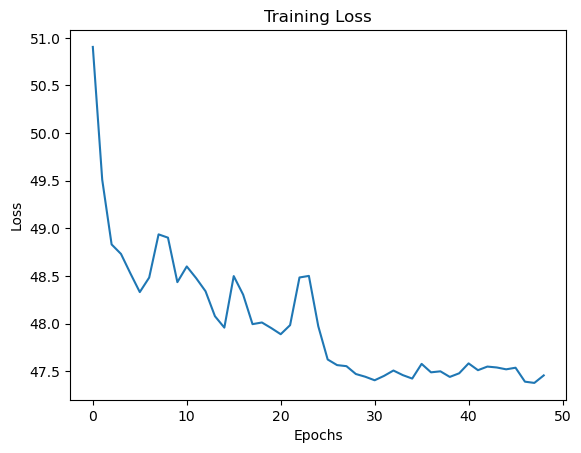

In [23]:
# Plot the loss.
plt.plot(np.arange(len(losses[1:])),losses[1:])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing of Model.

Load the presaved model.

In [27]:
model = torch.load('BasicCNN_model.pth')

### Visualize the results on test images.

Ground Truth, Regression : [0.39375    0.         0.596875   0.90833336] and Classification : [0. 0. 1.]
Model Output, Regression : [0.48556536 0.24388847 0.34042177 0.671225  ] and Classification : [0. 0. 1.]


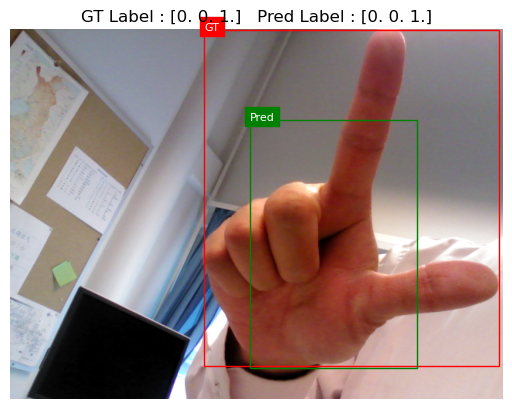

<Figure size 640x480 with 0 Axes>

In [62]:
for batch in test_dataloader:
    images, labels = batch

    model.eval()
    with torch.no_grad():
      images = images.to(device)
      labels = labels.to(device)
      output_regs, output_classes = model(images)
      image = images[0].cpu().numpy()
      label = labels[0].cpu().numpy()
      output_class, output_reg = output_classes[0], output_regs[0]
      output_class, output_reg = output_class.cpu().numpy(), output_reg.cpu().numpy()
      # output_class, output_reg = output_class.to(device), output_reg.to(device)
      print(f"Ground Truth, Regression : {label[3:]} and Classification : {label[:3]}")
      print(f"Model Output, Regression : {output_reg} and Classification : {output_class}")

    plt.imshow(image/255)
    rect_gt = plt.gca().add_patch(plt.Rectangle((label[3]*image.shape[1], label[4]*image.shape[0]), label[5]*image.shape[1], label[6]*image.shape[0], linewidth=1,
                                      edgecolor='r', facecolor='none',label='GT'))  # Add bounding box to the plot
    rect_pred = plt.gca().add_patch(plt.Rectangle((output_reg[0]*image.shape[1], output_reg[1]*image.shape[0]), output_reg[2]*image.shape[1], output_reg[3]*image.shape[0], linewidth=1,
                                      edgecolor='g', facecolor='none',label='Pred'))  # Add bounding box to the plot
    
    ## Add GT Label.
    plt.gca().text(label[3]*image.shape[1], label[4]*image.shape[0], 'GT', color='w',backgroundcolor='r', fontsize=8)
    ## Add Pred Label.
    plt.gca().text(output_reg[0]*image.shape[1], output_reg[1]*image.shape[0], 'Pred', color='w',backgroundcolor='g', fontsize=8)
    plt.title(f'GT Label : {label[:3]}   Pred Label : {output_class}')
    plt.axis('off')
    plt.show()
    rand_no = random.randint(1,10000)
    plt.savefig(f'BasicCNN_Test_{rand_no}.png')
    break